In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import torch
import numpy as np
from diffusers import StableCascadeDecoderPipeline, StableCascadePriorPipeline
from PIL import Image

In [2]:
prior = StableCascadePriorPipeline.from_pretrained("stabilityai/stable-cascade-prior", variant="bf16", torch_dtype=torch.bfloat16, cache_dir="../cache").to("cuda")
decoder = StableCascadeDecoderPipeline.from_pretrained("stabilityai/stable-cascade", variant="bf16", torch_dtype=torch.float16, cache_dir="../cache").to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([1, 1, 768]) torch.Size([1, 77, 1280]) torch.Size([1, 1, 1280]) torch.Size([1, 1, 1280])
torch.Size([1, 77, 1280])


  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([1, 77, 1280]) torch.Size([1, 1, 1280]) torch.Size([1, 16, 24, 24])


  0%|          | 0/10 [00:00<?, ?it/s]

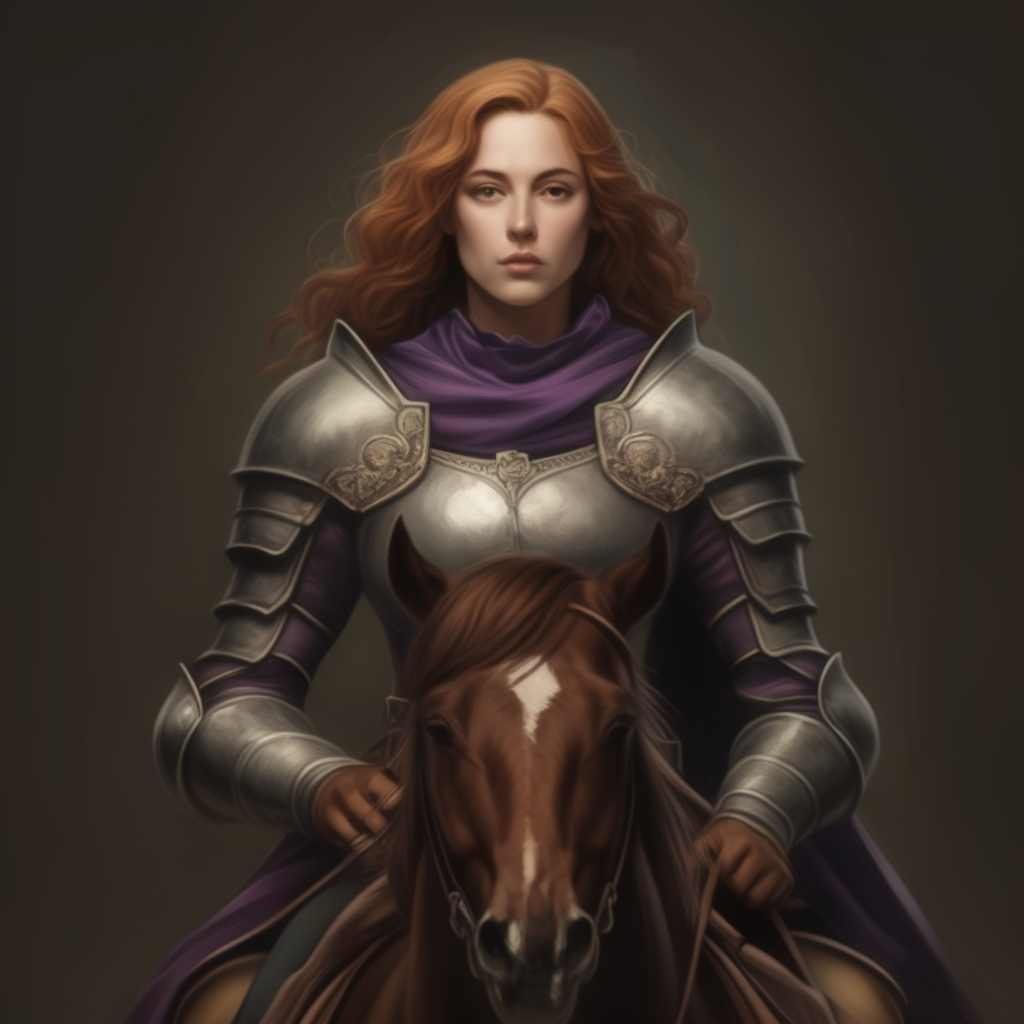

In [10]:
prompt = "a woman riding a horse"
negative_prompt = ""
image = Image.open("/home/naxos2-raid25/kneel027/home/kneel027/IP-Adapter_MEI/assets/images/woman.png")
image_embeds, _ = prior.encode_image([image], "cuda", torch.bfloat16, 1, 1)
prompt_embeds, prompt_embeds_pooled, negative_prompt_embeds, negative_prompt_embeds_pooled = prior.encode_prompt(prompt=prompt, device="cuda", num_images_per_prompt=1, batch_size=1, do_classifier_free_guidance=False)

print(image_embeds.shape, prompt_embeds.shape, prompt_embeds_pooled.shape, prompt_embeds_pooled[:,0].unsqueeze(0).shape)
# prompt_embeds = prompt_embeds_pooled[:,0].unsqueeze(0)
print(prompt_embeds.shape)
prior.enable_model_cpu_offload()
prior_output = prior(
    prompt_embeds=prompt_embeds,
    prompt_embeds_pooled=prompt_embeds_pooled,
    # prompt="",
    image_embeds=image_embeds,
    height=1024,
    width=1024,
    # negative_prompt_embeds=negative_prompt_embeds,
    guidance_scale=4.0,
    num_images_per_prompt=1,
    num_inference_steps=20
)
print(prior_output.prompt_embeds.shape, prior_output.prompt_embeds_pooled.shape, prior_output.image_embeddings.shape)

decoder.enable_model_cpu_offload()
decoder_output = decoder(
    image_embeddings=prior_output.image_embeddings.to(torch.float16),
    # prompt="",
    prompt_embeds=prior_output.prompt_embeds.to(torch.float16),
    prompt_embeds_pooled=prior_output.prompt_embeds_pooled.to(torch.float16),
    negative_prompt=negative_prompt,
    guidance_scale=0.0,
    output_type="pil",
    num_inference_steps=10
).images[0]
decoder_output